# Train a VAE on Cell Painting LINCS Data

In [1]:
import sys
import pathlib
import numpy as np
import pandas as pd
sys.path.insert(0, "../../scripts")
from utils import load_data


from pycytominer.cyto_utils import infer_cp_features


import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from sklearn.decomposition import PCA
from tensorflow import keras

from vae import VAE

from tensorflow.keras.models import Model, Sequential
import seaborn
import random as python_random
import tensorflow as tf
# import umap


/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps,
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:597: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#depr

In [2]:
def remove_moa(df):
    pipes = ['dopamine receptor agonist|serotonin receptor antagonist'
         'sodium channel blocker|T-type calcium channel blocker',
             'EGFR inhibitor|VEGFR inhibitor',
             'leukotriene receptor antagonist|lipoxygenase inhibitor',
            'acetylcholine receptor agonist|benzodiazepine receptor agonist']    
    moas =  []
    for pipe in pipes:
        moas.append(pipe)
        moas.append(pipe.split('|')[0])
        moas.append(pipe.split('|')[1])
    return df[~df.moa.isin(moas)]

In [3]:
data_splits = ["train", "test", "valid", "complete"]
data_dict = load_data(data_splits)

In [4]:
# Prepare data for training
meta_features = infer_cp_features(data_dict["train"], metadata=True)
cp_features = infer_cp_features(data_dict["train"])

moa_df_train = pd.read_csv("../3.application/repurposing_info_external_moa_map_resolved.tsv",sep='\t').set_index('broad_sample').reindex(index=data_dict['train']['Metadata_broad_sample']).reset_index().drop('Metadata_broad_sample',axis = 1)
data_dict['train'] = pd.concat([moa_df_train,data_dict['train']], axis=1)

moa_df_valid = pd.read_csv("../3.application/repurposing_info_external_moa_map_resolved.tsv",sep='\t').set_index('broad_sample').reindex(index=data_dict['valid']['Metadata_broad_sample']).reset_index().drop('Metadata_broad_sample',axis = 1)
data_dict['valid'] = pd.concat([moa_df_valid,data_dict['valid']], axis=1)

data_dict['train'] = remove_moa(data_dict['train'])
data_dict['valid'] = remove_moa(data_dict['valid'])

train_features_df = data_dict["train"].reindex(cp_features, axis="columns")
train_meta_df = data_dict["train"].reindex(meta_features, axis="columns")

test_features_df = data_dict["test"].reindex(cp_features, axis="columns")
test_meta_df = data_dict["test"].reindex(meta_features, axis="columns")

valid_features_df = data_dict["valid"].reindex(cp_features, axis="columns")
valid_meta_df = data_dict["valid"].reindex(meta_features, axis="columns")

complete_features_df = data_dict["complete"].reindex(cp_features, axis="columns")
complete_meta_df = data_dict["complete"].reindex(meta_features, axis="columns")


In [5]:
print(train_features_df.shape)
train_features_df.head(3)

(8029, 588)


,Cells_AreaShape_FormFactor,Cells_AreaShape_Orientation,Cells_AreaShape_Zernike_2_2,Cells_AreaShape_Zernike_3_1,Cells_AreaShape_Zernike_5_1,Cells_AreaShape_Zernike_6_2,Cells_AreaShape_Zernike_7_1,Cells_AreaShape_Zernike_7_7,Cells_AreaShape_Zernike_9_3,Cells_Correlation_Correlation_DNA_AGP,...,Nuclei_Texture_SumAverage_AGP_5_0,Nuclei_Texture_SumEntropy_AGP_10_0,Nuclei_Texture_SumEntropy_AGP_20_0,Nuclei_Texture_SumEntropy_AGP_5_0,Nuclei_Texture_SumEntropy_DNA_10_0,Nuclei_Texture_SumEntropy_DNA_20_0,Nuclei_Texture_SumEntropy_Mito_5_0,Nuclei_Texture_SumVariance_DNA_5_0,Nuclei_Texture_Variance_DNA_20_0,Nuclei_Texture_Variance_DNA_5_0
0,0.56071,0.63708,0.57961,0.51030,0.61695,0.30869,0.43981,0.79826,0.72477,0.68589,...,0.17858,0.29336,0.26447,0.30197,0.64786,0.49525,0.53512,0.40495,0.46056,0.43647
1,0.59702,0.55453,0.62561,0.47959,0.59022,0.33269,0.49875,0.88042,0.67159,0.61703,...,0.09030,0.15088,0.13334,0.14052,0.59229,0.49294,0.43221,0.33969,0.39208,0.36205
2,0.64623,0.59825,0.62822,0.52100,0.57452,0.26367,0.48172,0.86322,0.67588,0.69732,...,0.18125,0.23244,0.20723,0.24062,0.54642,0.43920,0.41183,0.30375,0.35385,0.33266


In [6]:
print(test_features_df.shape)
test_features_df.head(3)

(1037, 588)


,Cells_AreaShape_FormFactor,Cells_AreaShape_Orientation,Cells_AreaShape_Zernike_2_2,Cells_AreaShape_Zernike_3_1,Cells_AreaShape_Zernike_5_1,Cells_AreaShape_Zernike_6_2,Cells_AreaShape_Zernike_7_1,Cells_AreaShape_Zernike_7_7,Cells_AreaShape_Zernike_9_3,Cells_Correlation_Correlation_DNA_AGP,...,Nuclei_Texture_SumAverage_AGP_5_0,Nuclei_Texture_SumEntropy_AGP_10_0,Nuclei_Texture_SumEntropy_AGP_20_0,Nuclei_Texture_SumEntropy_AGP_5_0,Nuclei_Texture_SumEntropy_DNA_10_0,Nuclei_Texture_SumEntropy_DNA_20_0,Nuclei_Texture_SumEntropy_Mito_5_0,Nuclei_Texture_SumVariance_DNA_5_0,Nuclei_Texture_Variance_DNA_20_0,Nuclei_Texture_Variance_DNA_5_0
0,0.52664,0.59293,0.51636,0.52824,0.54415,0.23948,0.53361,0.84625,0.65881,0.86971,...,0.74413,0.58353,0.54654,0.63600,0.50501,0.39338,0.46080,0.25924,0.29724,0.27556
1,0.61343,0.57882,0.62454,0.51049,0.57508,0.31691,0.49077,0.89145,0.65811,0.66082,...,0.12499,0.20488,0.18676,0.20580,0.58773,0.47783,0.42619,0.34683,0.39642,0.37092
2,0.55123,0.61050,0.53085,0.65280,0.54356,0.16767,0.50521,0.93703,0.77958,0.63413,...,0.19249,0.13665,0.13293,0.13816,0.58333,0.52931,0.31068,0.40967,0.48646,0.45058


In [7]:
print(complete_features_df.shape)
complete_features_df.head(3)

(10368, 588)


,Cells_AreaShape_FormFactor,Cells_AreaShape_Orientation,Cells_AreaShape_Zernike_2_2,Cells_AreaShape_Zernike_3_1,Cells_AreaShape_Zernike_5_1,Cells_AreaShape_Zernike_6_2,Cells_AreaShape_Zernike_7_1,Cells_AreaShape_Zernike_7_7,Cells_AreaShape_Zernike_9_3,Cells_Correlation_Correlation_DNA_AGP,...,Nuclei_Texture_SumAverage_AGP_5_0,Nuclei_Texture_SumEntropy_AGP_10_0,Nuclei_Texture_SumEntropy_AGP_20_0,Nuclei_Texture_SumEntropy_AGP_5_0,Nuclei_Texture_SumEntropy_DNA_10_0,Nuclei_Texture_SumEntropy_DNA_20_0,Nuclei_Texture_SumEntropy_Mito_5_0,Nuclei_Texture_SumVariance_DNA_5_0,Nuclei_Texture_Variance_DNA_20_0,Nuclei_Texture_Variance_DNA_5_0
0,0.57016,0.59500,0.57370,0.50690,0.56160,0.27321,0.45448,0.83747,0.68635,0.68973,...,0.16426,0.22701,0.20854,0.22897,0.53738,0.43547,0.41635,0.28933,0.34017,0.31368
1,0.54840,0.53949,0.58096,0.53694,0.55009,0.28114,0.53594,0.86929,0.66026,0.71317,...,0.18411,0.23932,0.21854,0.24763,0.56995,0.47084,0.37764,0.32148,0.36964,0.34328
2,0.56057,0.59621,0.59116,0.50418,0.55679,0.29305,0.49221,0.87813,0.71747,0.72229,...,0.17564,0.23366,0.21743,0.23448,0.56980,0.47254,0.39575,0.31969,0.36626,0.34086


In [39]:
# VAE of one layer
encoder_architecture = [250]
decoder_architecture = [250]



In [40]:
# model from optimal hyperparameters for onelayer obtained from 1.optimize
cp_vae = VAE(
    input_dim=train_features_df.shape[1],
    latent_dim=10,
    batch_size=96,
    encoder_batch_norm=True,
    epochs=100,
    learning_rate=0.001,
    encoder_architecture=encoder_architecture,
    decoder_architecture=decoder_architecture,
    beta=1,
    verbose=True,
)
cp_vae.compile_vae()

/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [41]:
cp_vae.train(x_train=train_features_df, x_test=valid_features_df)

Epoch 1/100
84/84 [==============================] - 3s 12ms/step - loss: 33.8366 - recon: 31.2544 - kl: 2.5822 - mmd: 0.0000e+00 - val_loss: 24.3519 - val_recon: 18.5942 - val_kl: 5.7577 - val_mmd: 0.0000e+00
Epoch 2/100
84/84 [==============================] - 1s 7ms/step - loss: 9.7055 - recon: 7.9213 - kl: 1.7842 - mmd: 0.0000e+00 - val_loss: 15.3030 - val_recon: 10.6274 - val_kl: 4.6756 - val_mmd: 0.0000e+00
Epoch 3/100
84/84 [==============================] - 1s 7ms/step - loss: 7.4154 - recon: 5.9901 - kl: 1.4253 - mmd: 0.0000e+00 - val_loss: 11.5911 - val_recon: 7.9310 - val_kl: 3.6600 - val_mmd: 0.0000e+00
Epoch 4/100
84/84 [==============================] - 1s 7ms/step - loss: 6.0106 - recon: 4.8913 - kl: 1.1193 - mmd: 0.0000e+00 - val_loss: 6.1713 - val_recon: 4.8614 - val_kl: 1.3099 - val_mmd: 0.0000e+00
Epoch 5/100
84/84 [==============================] - 1s 7ms/step - loss: 5.2706 - recon: 4.2819 - kl: 0.9887 - mmd: 0.0000e+00 - val_loss: 5.4654 - val_recon: 4.1963 - val_

Epoch 41/100
84/84 [==============================] - 1s 7ms/step - loss: 3.9499 - recon: 3.0209 - kl: 0.9291 - mmd: 0.0000e+00 - val_loss: 3.9753 - val_recon: 2.8826 - val_kl: 1.0927 - val_mmd: 0.0000e+00
Epoch 42/100
84/84 [==============================] - 1s 7ms/step - loss: 3.9738 - recon: 3.0312 - kl: 0.9426 - mmd: 0.0000e+00 - val_loss: 3.8882 - val_recon: 2.8932 - val_kl: 0.9950 - val_mmd: 0.0000e+00
Epoch 43/100
84/84 [==============================] - 1s 7ms/step - loss: 3.9131 - recon: 2.9680 - kl: 0.9451 - mmd: 0.0000e+00 - val_loss: 4.0115 - val_recon: 3.0666 - val_kl: 0.9449 - val_mmd: 0.0000e+00
Epoch 44/100
84/84 [==============================] - 1s 7ms/step - loss: 3.9376 - recon: 2.9725 - kl: 0.9651 - mmd: 0.0000e+00 - val_loss: 3.7627 - val_recon: 2.6547 - val_kl: 1.1080 - val_mmd: 0.0000e+00
Epoch 45/100
84/84 [==============================] - 1s 7ms/step - loss: 3.9484 - recon: 2.9739 - kl: 0.9745 - mmd: 0.0000e+00 - val_loss: 3.7751 - val_recon: 2.7227 - val_kl:

Epoch 81/100
84/84 [==============================] - 1s 7ms/step - loss: 3.5766 - recon: 2.6112 - kl: 0.9654 - mmd: 0.0000e+00 - val_loss: 3.4824 - val_recon: 2.4879 - val_kl: 0.9945 - val_mmd: 0.0000e+00
Epoch 82/100
84/84 [==============================] - 1s 7ms/step - loss: 3.6113 - recon: 2.6295 - kl: 0.9818 - mmd: 0.0000e+00 - val_loss: 3.4346 - val_recon: 2.4006 - val_kl: 1.0340 - val_mmd: 0.0000e+00
Epoch 83/100
84/84 [==============================] - 1s 7ms/step - loss: 3.5535 - recon: 2.5780 - kl: 0.9755 - mmd: 0.0000e+00 - val_loss: 3.4652 - val_recon: 2.4722 - val_kl: 0.9930 - val_mmd: 0.0000e+00
Epoch 84/100
84/84 [==============================] - 1s 7ms/step - loss: 3.6073 - recon: 2.6276 - kl: 0.9797 - mmd: 0.0000e+00 - val_loss: 3.4766 - val_recon: 2.5113 - val_kl: 0.9653 - val_mmd: 0.0000e+00
Epoch 85/100
84/84 [==============================] - 1s 7ms/step - loss: 3.5703 - recon: 2.5957 - kl: 0.9746 - mmd: 0.0000e+00 - val_loss: 3.5011 - val_recon: 2.4194 - val_kl:

In [42]:
cp_vae.vae

In [43]:
cp_vae.vae.evaluate(test_features_df)

33/33 [==============================] - 0s 2ms/step - loss: 3.3118 - recon: 2.3810 - kl: 0.9308 - mmd: 0.0000e+00


[3.3118042945861816, 2.380993127822876, 0.9308114647865295, 0.0]

In [44]:
# Save training performance
history_df = pd.DataFrame(cp_vae.vae.history.history)
history_df

""


In [45]:
history_df.to_csv('training_data/level5_training_vanilla_leaveIntermediateOut.csv')

In [46]:
plt.figure(figsize=(10, 5))
plt.plot(history_df["loss"], label="Training data")
plt.plot(history_df["val_loss"], label="Validation data")
plt.title("Loss for VAE training on Cell Painting Level 5 data")
plt.ylabel("MSE + KL Divergence")
plt.xlabel("No. Epoch")
plt.legend()
plt.show()

KeyError: 'loss'

<Figure size 720x360 with 0 Axes>

In [25]:
reconstruction = pd.DataFrame(cp_vae.vae.predict(test_features_df), columns=cp_features)
(sum(sum((np.array(test_features_df) - np.array(reconstruction)) ** 2))) ** 0.5

47.86316166790343

<AxesSubplot:>

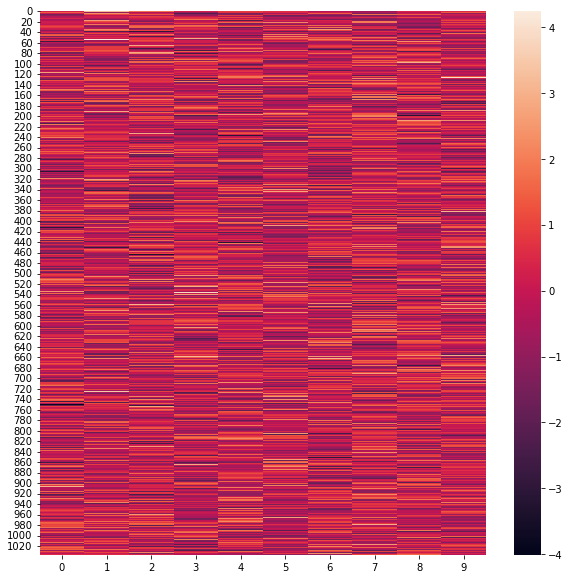

In [26]:
#latent space heatmap
fig, ax = plt.subplots(figsize=(10, 10))
encoder = cp_vae.encoder_block["encoder"]
latent = np.array(encoder.predict(test_features_df)[2])
seaborn.heatmap(latent, ax=ax)

In [27]:
#original vs reconstructed heatmap
reconstruction = pd.DataFrame(cp_vae.vae.predict(test_features_df), columns=cp_features)
pca = PCA(n_components=2).fit(test_features_df)
pca_reconstructed_latent_df = pd.DataFrame(pca.transform(reconstruction))
pca_test_latent_df = pd.DataFrame(pca.transform(test_features_df))

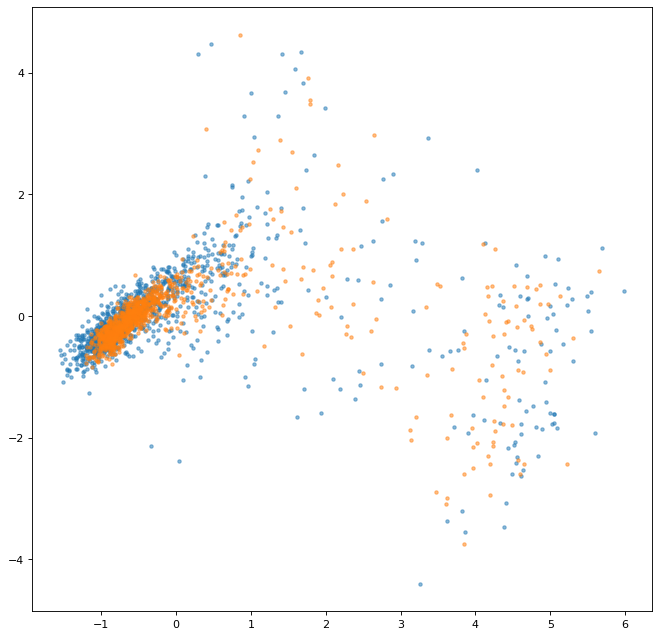

In [28]:
figure(figsize=(10, 10), dpi=80)
plt.scatter(pca_test_latent_df[0],pca_test_latent_df[1], marker = ".", alpha = 0.5)
plt.scatter(pca_reconstructed_latent_df[0],pca_reconstructed_latent_df[1], marker = ".", alpha = 0.5)

In [29]:
pca = PCA(n_components=50).fit(test_features_df)
pca_reconstructed_latent_df = pd.DataFrame(pca.transform(reconstruction))
pca_test_latent_df = pd.DataFrame(pca.transform(test_features_df))

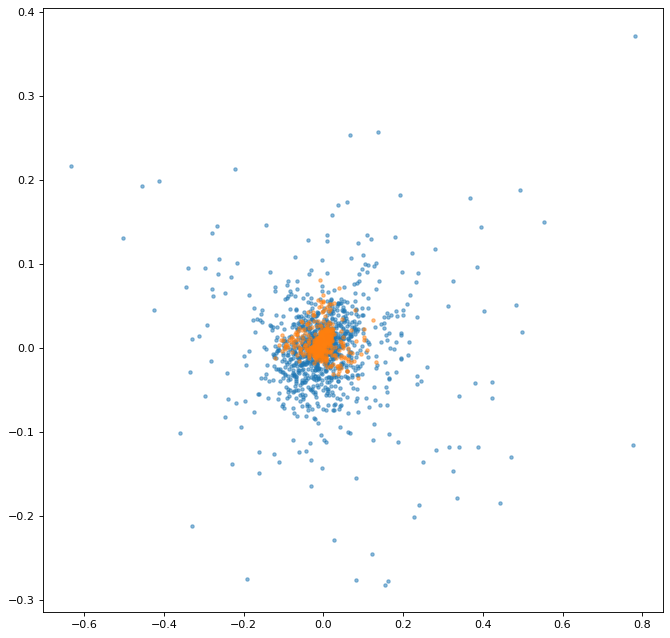

In [30]:
figure(figsize=(10, 10), dpi=80)
plt.scatter(pca_test_latent_df[21],pca_test_latent_df[43], marker = ".", alpha = 0.5)
plt.scatter(pca_reconstructed_latent_df[21],pca_reconstructed_latent_df[43], marker = ".", alpha = 0.5)

<AxesSubplot:>

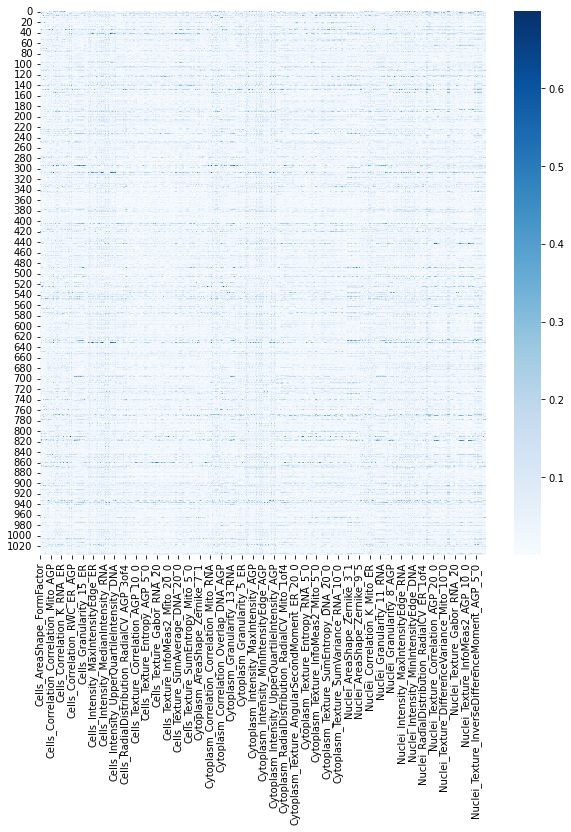

In [31]:
#difference between original and reconstructed heatmap
difference = abs(reconstruction - test_features_df)
fig, ax = plt.subplots(figsize=(10, 10))
seaborn.heatmap(difference, ax=ax, cmap="Blues")

<AxesSubplot:>

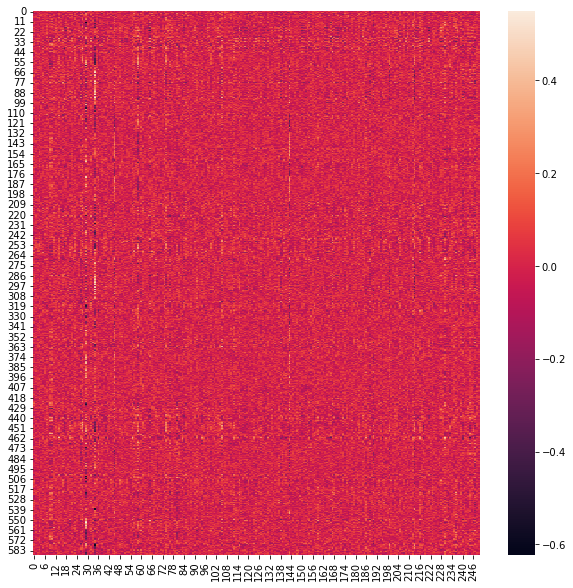

In [32]:
#encoder heatmap
weights = cp_vae.encoder_block["encoder"].get_weights()
fig, ax = plt.subplots(figsize=(10, 10))
seaborn.heatmap(weights[0], ax=ax)

In [33]:
decoder = cp_vae.decoder_block["decoder"]

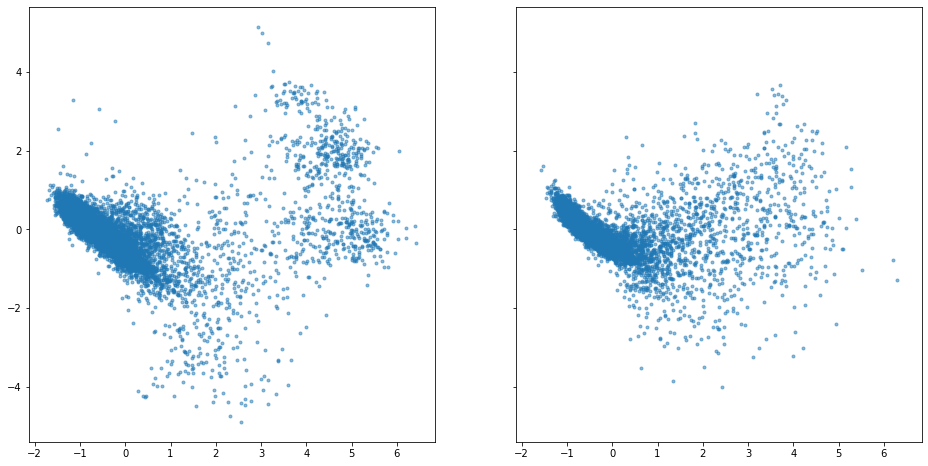

In [34]:

pca_training = PCA(n_components=2).fit(train_features_df)

simulated_df = pd.DataFrame(np.random.normal(size=(8294, 10)), columns=np.arange(0,10))
reconstruction_of_simulated = decoder.predict(simulated_df)
pca_reconstruction_of_simulated = pd.DataFrame(pca_training.transform(reconstruction_of_simulated))
pca_train_latent_df = pd.DataFrame(pca_training.transform(train_features_df))

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16,8), sharey = True, sharex = True)
ax1.scatter(pca_train_latent_df[0],pca_train_latent_df[1], marker = ".", alpha = 0.5)
ax2.scatter(pca_reconstruction_of_simulated[0],pca_reconstruction_of_simulated[1], marker = ".", alpha = 0.5)

In [35]:
from scipy.spatial.distance import directed_hausdorff
max(directed_hausdorff(reconstruction_of_simulated, train_features_df)[0],directed_hausdorff(train_features_df,reconstruction_of_simulated)[0])

5.855550175784144

In [36]:
#NOTE: IF YOU RUN THIS, YOU WILL NOT BE ABLE TO REPRODUCE THE EXACT RESULTS IN THE EXPERIMENT
latent_complete = np.array(encoder.predict(complete_features_df)[2])
latent_df = pd.DataFrame(latent_complete)
latent_df.to_csv("../3.application/level5Latent_vanilla_leaveIntermediateOut.csv")

In [ ]:
# reducer = umap.UMAP()
# latent_embedding = reducer.fit_transform(latent_df)

In [ ]:
# figure(figsize=(10, 10), dpi=80)
# plt.scatter(
#     latent_embedding[:, 0],
#     latent_embedding[:, 1],
#     marker = '.'
# )

In [37]:
#NOTE: IF YOU RUN THIS, YOU WILL NOT BE ABLE TO REPRODUCE THE EXACT RESULTS IN THE EXPERIMENT
decoder.save("models/level5Decoder_vanilla_leaveIntermediateOut")

2021-12-23 18:01:38.653213: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: models/level5Decoder_vanilla_leaveIntermediateOut/assets


In [38]:
encoder.save("models/level5Encoder_vanilla_leaveIntermediateOut")

INFO:tensorflow:Assets written to: models/level5Encoder_vanilla_leaveIntermediateOut/assets
